### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [118]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [119]:
# Imports
import numpy as np
import imageio.v3 as iio
import random


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [120]:
# Global variables
POPULATION_SIZE = 40
IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


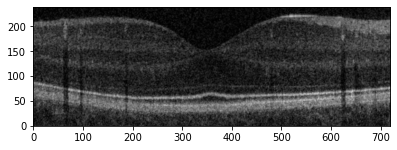

In [121]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [122]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)
    
    def cost_internal(self, bg_colour):  
        cost_size = (self.r - 30)**2 / 30**2  # Encourage sizes closer to ideal line width
        cost_shape = (self.dr + abs(self.dgamma)) * 0.1  # Reduce impact of shape deviation
        cost_colour = (abs(self.colour - bg_colour) * 2)  # Increase impact of colour matching
        return cost_size + cost_shape + cost_colour

    def cost_group(self, other_worms, preferred_distance=10):
        cost_group = 0
        for worm in other_worms:
            distance = np.sqrt((self.x - worm.x)**2 + (self.y - worm.y)**2)
            if distance < preferred_distance:
                cost_group += (preferred_distance - distance)**2 / preferred_distance**2
        return cost_group

    def cost_environmental(self, image, radius=5):
        xmin = max(0, int(round(self.x - radius)))
        xmax = min(image.shape[1], int(round(self.x + radius)))
        ymin = max(0, int(round(self.y - radius)))
        ymax = min(image.shape[0], int(round(self.y + radius)))
        local_area = image[ymin:ymax, xmin:xmax]
        local_intensity = np.mean(local_area) / 255.0
        return abs(self.colour - local_intensity) * 3  


In [123]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [124]:
class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.fitness = float('inf')  
        self.worm = Camo_Worm(*self.chromosome)
        self.internal_fitness = 0
        self.group_fitness = 0
        self.environmental_fitness = 0

    def get_worm(self):
        return self.worm

    @classmethod
    def create_gnome(cls, imshape, init_params):
        return random_worm(imshape, init_params)

    def cal_fitness(self, population, image):
        bg_colour = image[int(self.worm.y), int(self.worm.x)] / 255.0
        internal_cost = self.worm.cost_internal(bg_colour)
        group_cost = self.worm.cost_group([worm.worm for worm in population if worm.worm != self.worm])
        environmental_cost = self.worm.cost_environmental(image)
        
        self.internal_fitness = 1 / (1 + internal_cost)
        self.group_fitness = 1 / (1 + group_cost)
        self.environmental_fitness = 1 / (1 + environmental_cost)
        self.fitness = self.internal_fitness + self.group_fitness + self.environmental_fitness

    def mate(self, partner):
        child_chromosome1 = []
        child_chromosome2 = []
        for gp1, gp2 in zip(self.chromosome, partner.chromosome):
            prob = random.random()
            if prob < 0.85:
                child_chromosome1.append(gp1)
                child_chromosome2.append(gp2)
            elif prob < 0.90:
                child_chromosome1.append(gp2)
                child_chromosome2.append(gp1)
            else:
                mutate_value = random.uniform(-0.1, 0.1)
                child_chromosome1.append(gp1 + mutate_value)
                child_chromosome2.append(gp2 + mutate_value)
        return Individual(child_chromosome1), Individual(child_chromosome2), Individual(child_chromosome2)
    

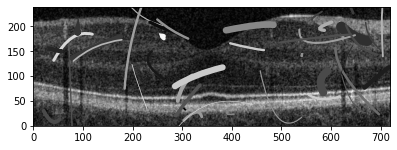

In [125]:
def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return [midx, midy, r, theta, dr, dgamma, width, colour]
def initialise_clew(size, imshape, init_params):
    clew = []
    for i in range(size):
        chromosome = random_worm(imshape, init_params)
        individual = Individual(chromosome)
        clew.append(individual.get_worm()) 
    return clew

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

In [126]:

def calculate_fitness_scores(individual, population, image):
    # 对每个成本计算适应度得分
    bg_colour = image[int(individual.worm.y), int(individual.worm.x)] / 255.0
    internal_cost = individual.worm.cost_internal(bg_colour)
    group_cost = individual.worm.cost_group([ind.worm for ind in population if ind != individual])
    environmental_cost = individual.worm.cost_environmental(image)
    
    # 适应度转换，这里可以调整权重
    individual.internal_fitness = 1 / (1 + internal_cost)
    individual.group_fitness = 1 / (1 + group_cost)
    individual.environmental_fitness = 1 / (1 + environmental_cost)

def adjust_individual(individual, image_shape):
    # 根据适应度得分最低的成本调整蠕虫属性
    min_fitness = min(individual.internal_fitness, individual.group_fitness, individual.environmental_fitness)
    if min_fitness == individual.internal_fitness:
        # 显著增加或减少半径
        change = random.uniform(-10, 10)  # 调整变化范围
        new_r = max(1, individual.worm.r + change)
        individual.worm.r = min(image_shape[0]/2, new_r)  # 确保半径不超过图像高度的一半
    elif min_fitness == individual.group_fitness:
        # 根据当前位置和图像边界调整位置
        individual.worm.x = max(0, min(image_shape[1]-1, individual.worm.x + random.uniform(-20, 20)))
        individual.worm.y = max(0, min(image_shape[0]-1, individual.worm.y + random.uniform(-20, 20)))
    elif min_fitness == individual.environmental_fitness:
        # 更大范围地调整颜色
        new_colour = individual.worm.colour + random.uniform(-0.1, 0.1)  # 增大颜色调整范围
        individual.worm.colour = max(0, min(1, new_colour))  # 确保颜色值在0-1的范围内



def genetic_algorithm(image, initial_params, population_size, generations):
    population = [Individual(random_worm(image.shape, initial_params)) for _ in range(population_size)]

    for generation in range(generations):
        print(f"Running generation {generation + 1} of {generations}")

        # 计算适应度并调整个体
        for individual in population:
            calculate_fitness_scores(individual, population, image)
            adjust_individual(individual, image.shape)

        # 输出这一代的适应度统计信息
        print(f"Generation {generation + 1} has {len(population)} worms")
        total_internal_cost = sum(1/individual.internal_fitness - 1 for individual in population)
        total_group_cost = sum(1/individual.group_fitness - 1 for individual in population)
        total_environmental_cost = sum(1/individual.environmental_fitness - 1 for individual in population)
        print(f"Total internal cost: {total_internal_cost}, Total group cost: {total_group_cost}, Total environmental cost: {total_environmental_cost}")

        # 选择和创建新一代
        selected = select_best_individuals(population, int(population_size * 0.5))
        population = create_next_generation(selected, population_size)

        # 可视化当前种群状态
        visualize_population([ind.worm for ind in population], image)

    return population


def select_best_individuals(population, num_to_select):
    # 根据适应度排序，选择适应度最高的一半
    sorted_population = sorted(population, key=lambda x: x.fitness, reverse=True)
    return sorted_population[:num_to_select]

def create_next_generation(selected, total_population_size):
    new_generation = []
    while len(new_generation) < total_population_size:
        parent1 = random.choice(selected)
        parent2 = random.choice(selected)
        child1, child2,_ = parent1.mate(parent2)
        new_generation.extend([child1, child2])
    return new_generation[:total_population_size]


def visualize_population(worms, image):
    drawing = Drawing(image)
    drawing.add_worms(worms)  
    drawing.show()
    
optimized_clew = genetic_algorithm(image, (40, 30, 1), 40, 10)

# 最终可视化
drawing = Drawing(image)
drawing.add_worms([ind.get_worm() for ind in optimized_clew])
drawing.show()


Running generation 1 of 10
Running generation 2 of 10
Running generation 3 of 10
Running generation 4 of 10
Running generation 5 of 10
Running generation 6 of 10
Running generation 7 of 10
Running generation 8 of 10
Running generation 9 of 10
Running generation 10 of 10
Generation 10 has 40 worms


ZeroDivisionError: division by zero

&copy; Cara MacNish, UWA, 2024